# XgBoost Classifier for Predicting PV energy generation   

In [133]:
# Data manipulation and processing
import pandas as pd
import numpy as np

# Machine learning and model evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# XGBoost model
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import shap  # SHAP library for feature importance analysis

# Performance metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt



## Loading preprocessed data

In [134]:
# Step 1: Load the dataset
file_path = 'solar_data_with_temperature_adjusted_irradiance.csv'
data = pd.read_csv(
    file_path,
    index_col=[0],  # Use 'time' as the index
    parse_dates=[0]  # Parse the 'time' column as datetime
).drop(columns=['Year', 'Month', 'Day', 'Hour', 'Minute'])


In [135]:
split = data.index[int(len(data) * 0.7)]

train = data.loc[data.index <= split].copy()
test = data.loc[data.index > split].copy()


<Axes: title={'center': 'Tilted Irradiance'}, xlabel='time'>

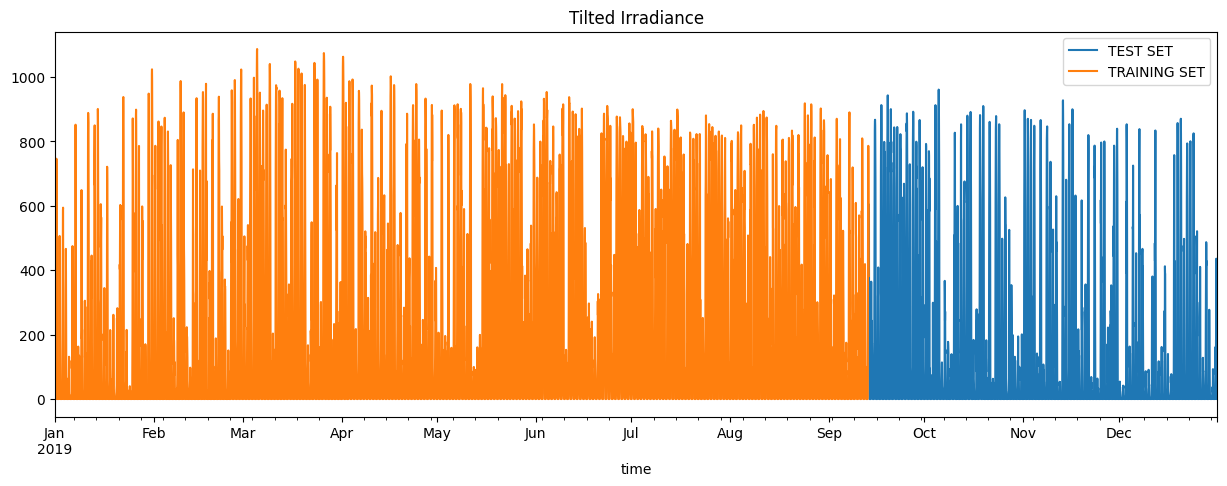

In [136]:
# Step 5: Plotting the Tilted Irradiance
test_set = test['Tilted Irradiance (Adjusted)'].rename('TEST SET').to_frame()  # Convert Series to DataFrame
training_set = train['Tilted Irradiance (Adjusted)'].rename('TRAINING SET').to_frame()  # Convert Series to DataFrame
combined_sets = test_set.join(training_set, how='outer')  # Combine the two DataFrames
combined_sets.plot(figsize=(15,5), title='Tilted Irradiance', style='-')  # Changed style to '-' to connect points

A closer look on the dataset

<Axes: title={'center': 'Tilted Irradiance Around Split'}, xlabel='time'>

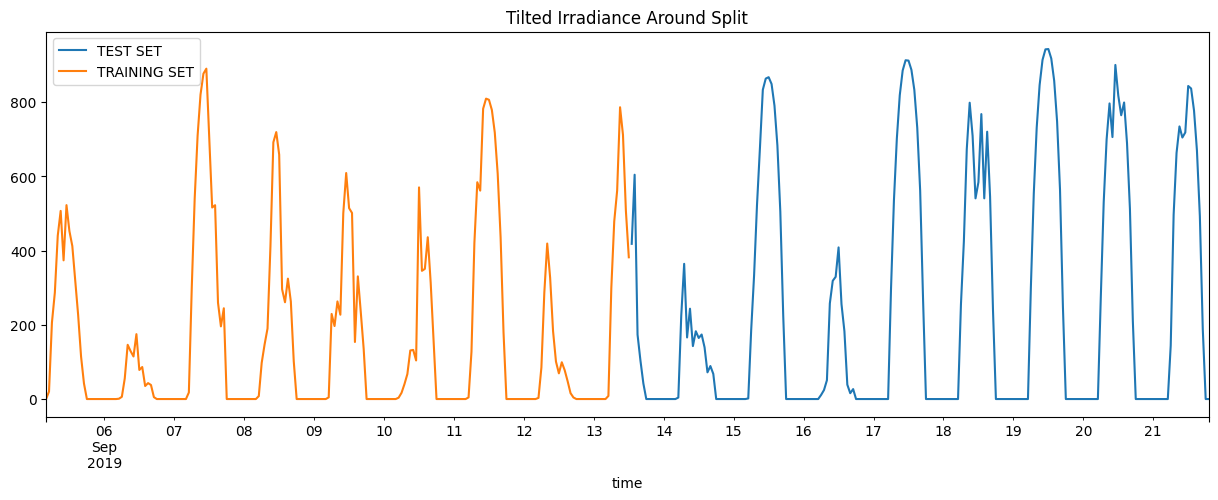

In [137]:
# Step 5: Plotting the Tilted Irradiance
test_set = test['Tilted Irradiance (Adjusted)'].rename('TEST SET').to_frame()  # Convert Series to DataFrame
training_set = train['Tilted Irradiance (Adjusted)'].rename('TRAINING SET').to_frame()  # Convert Series to DataFrame
combined_sets = test_set.join(training_set, how='outer')  # Combine the two DataFrames
# Selecting only the 1000 data points around the split
split_index = combined_sets.index.get_loc(split)
division_points = combined_sets.iloc[split_index-200:split_index+200]
division_points.plot(figsize=(15,5), title='Tilted Irradiance Around Split', style='-')

In [138]:
def create_features(data, label = None):
    # Step 2: Separate the features (X) and the target (y)
    X = data[['GHI', 'DNI', 'DHI', 'Temperature']]  # Features
    if label:
        y = data[label]
        return X, y
    return X

X_train, y_train = create_features(train, label='Tilted Irradiance (Adjusted)')
X_test, y_test = create_features(test, label='Tilted Irradiance (Adjusted)')




## Creating trasforming pipelines 

In [139]:
# Step 6: Apply ColumnTransformer for preprocessing to the dataset
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['GHI', 'DNI', 'DHI', 'Temperature']),  # Scale numerical features
    ]
)

## Initializing XGBoost model

In [140]:
# Step 7: Initialize the XGBoost model
xgb_model = XGBRegressor(n_estimators = 10000)

# Step 8: Create the final pipeline
final_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', xgb_model)
])

# Step 9: Define the parameter grid for GridSearchCV
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
}


# Initialize and fit GridSearchCV
grid_search = GridSearchCV(estimator=final_pipeline,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',  # Use MSE for regression
                           cv=3,  # Number of cross-validation folds
                           verbose=1,
                           n_jobs=-1)  # Use all available cores



## Hyperparameter tuning using GridSearchCV

In [141]:
# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Extract the best pipeline
best_pipeline = grid_search.best_estimator_

# Access the XGBRegressor model inside the pipeline
xgb_model = best_pipeline.named_steps['regressor']

# Manually fit the XGBRegressor with early stopping and eval_set
xgb_model.fit(
    X_train, 
    y_train, 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    #early_stopping_rounds=50,
    verbose=True
)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
[0]	validation_0-rmse:275.16118	validation_1-rmse:242.87115
[1]	validation_0-rmse:248.76542	validation_1-rmse:218.06581
[2]	validation_0-rmse:224.90332	validation_1-rmse:197.20875
[3]	validation_0-rmse:203.46771	validation_1-rmse:176.59289
[4]	validation_0-rmse:184.07474	validation_1-rmse:158.54856
[5]	validation_0-rmse:166.62993	validation_1-rmse:143.17703
[6]	validation_0-rmse:150.78248	validation_1-rmse:128.85761
[7]	validation_0-rmse:136.58145	validation_1-rmse:115.69913
[8]	validation_0-rmse:123.75941	validation_1-rmse:103.67810
[9]	validation_0-rmse:112.18600	validation_1-rmse:93.28061
[10]	validation_0-rmse:101.80138	validation_1-rmse:83.99251
[11]	validation_0-rmse:92.43426	validation_1-rmse:75.93658
[12]	validation_0-rmse:84.05284	validation_1-rmse:68.69036
[13]	validation_0-rmse:76.38368	validation_1-rmse:62.76457
[14]	validation_0-rmse:69.50085	validation_1-rmse:56.80209
[15]	validation_0-rmse:63.33084	validation_1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [142]:
test['Prediction'] = xgb_model.predict(X_test)

# Plotting results

In [143]:
all = pd.concat([test, train], sort = False)

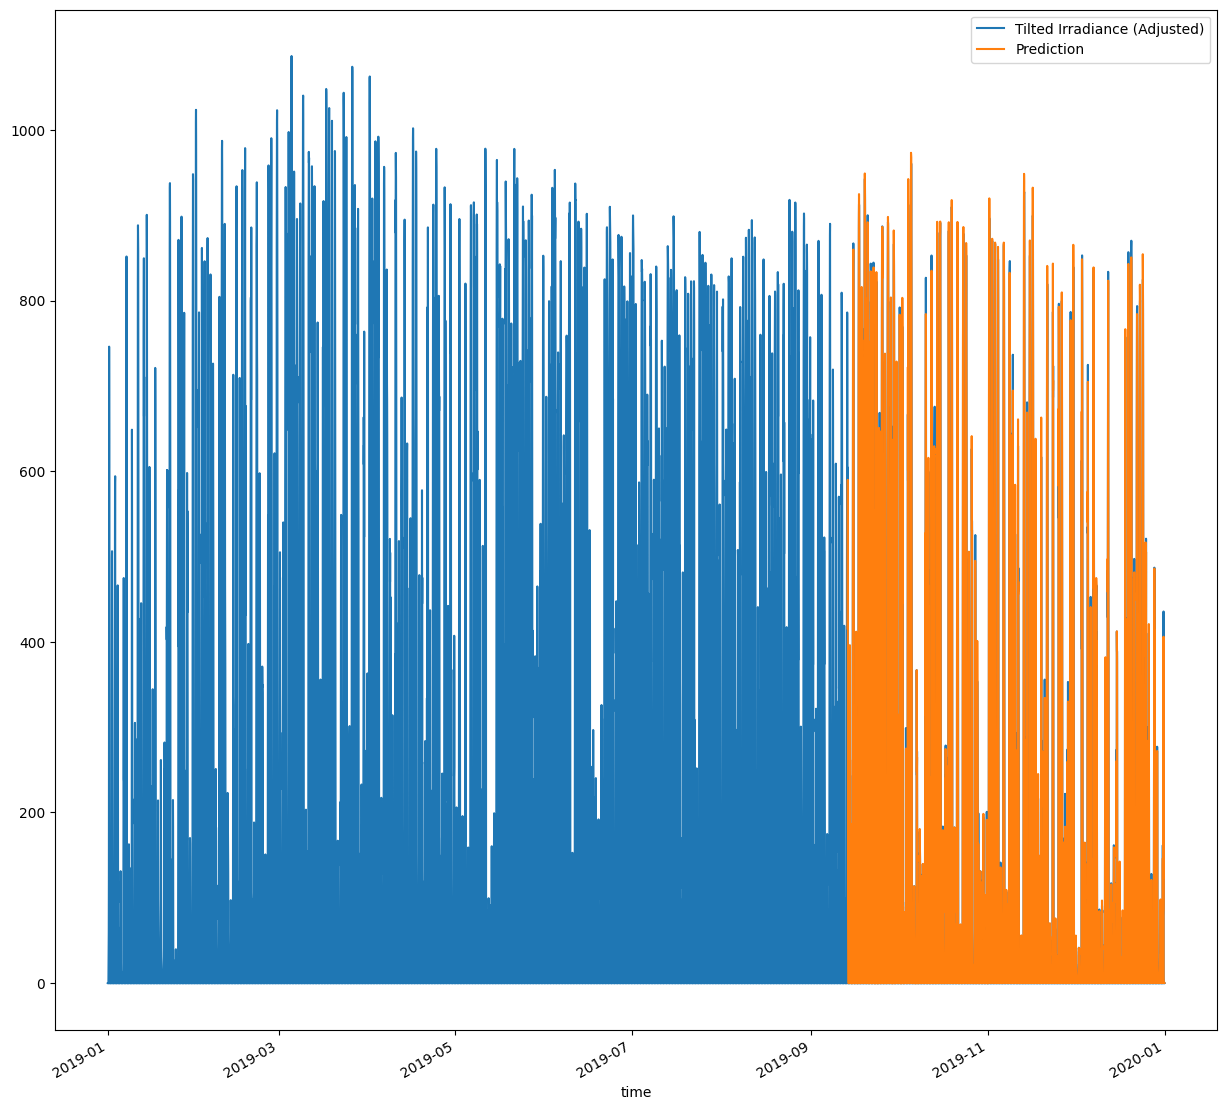

In [144]:
_ = all[['Tilted Irradiance (Adjusted)', 'Prediction']].plot(figsize=(15,15))




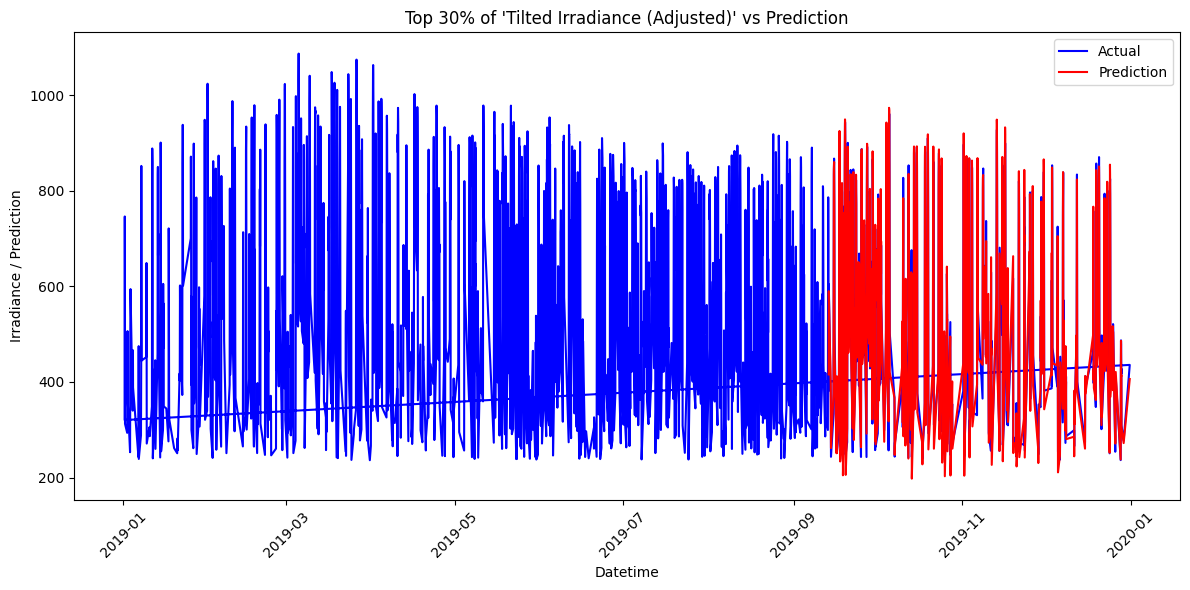

In [145]:
import matplotlib.pyplot as plt

# Step 1: Calculate the threshold for the top 10% of 'Tilted Irradiance (Adjusted)'
top_10_percent_threshold = all['Tilted Irradiance (Adjusted)'].quantile(0.70)

# Step 2: Filter the data to only include the top 10% based on 'Tilted Irradiance (Adjusted)'
top_10_percent_data = all[all['Tilted Irradiance (Adjusted)'] >= top_10_percent_threshold]

# Step 3: Plot the filtered data as a line plot for actual and predicted data
plt.figure(figsize=(12, 6))

# Plot the actual data (blue)
plt.plot(top_10_percent_data.index, top_10_percent_data['Tilted Irradiance (Adjusted)'], label='Actual', color='blue')

# Plot the predicted data (red)
plt.plot(top_10_percent_data.index, top_10_percent_data['Prediction'], label='Prediction', color='red')

# Optional: Add titles, labels, and a legend
plt.title("Top 30% of 'Tilted Irradiance (Adjusted)' vs Prediction")
plt.xlabel("Datetime")  # or "Index" if the index is not datetime
plt.ylabel("Irradiance / Prediction")
plt.legend()

# Rotate x-axis labels if necessary for readability
plt.xticks(rotation=45)

# Show the plot with tight layout for spacing
plt.tight_layout()
plt.show()


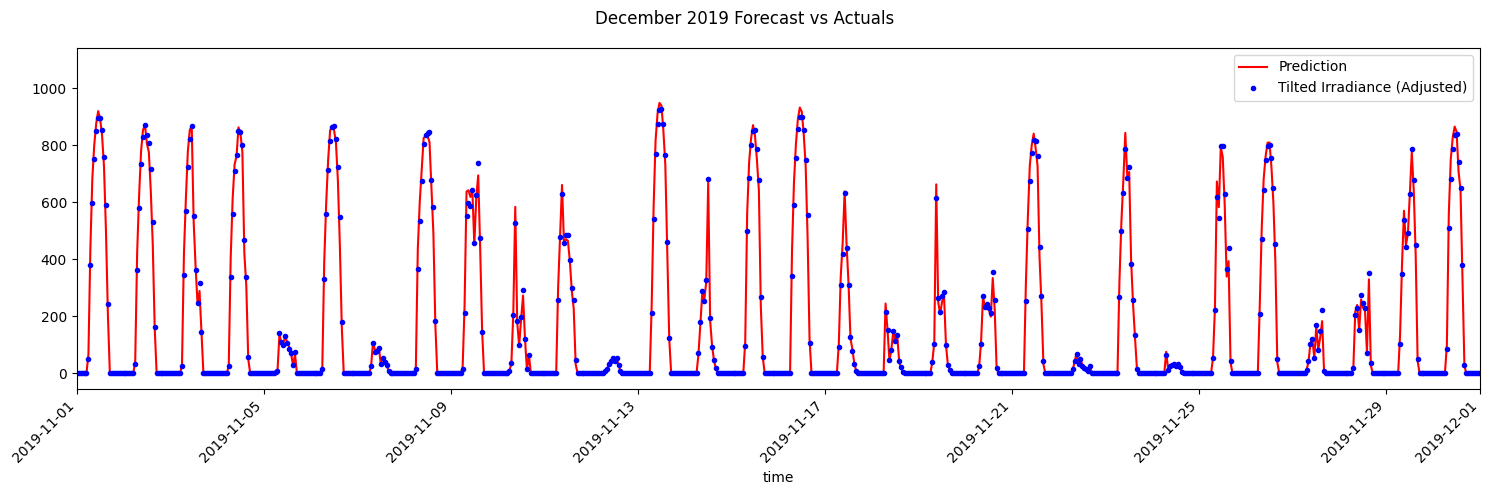

In [146]:
import matplotlib.pyplot as plt

# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

# Plot actual vs predicted MW values, with distinct line styles
_ = all[['Prediction', 'Tilted Irradiance (Adjusted)']].plot(ax=ax,
                                                style=['-', '.'],
                                                color=['red', 'blue'])  # Red for Prediction, Blue for Actuals

# Set x-axis bounds to zoom in on January 2015
ax.set_xlim(pd.to_datetime('2019-11-01'), pd.to_datetime('2019-12-01'))

# Set y-axis limits to match the range from 0 to 60000
#ax.set_ylim(0, 60000)

# Add a title for the plot
plt.suptitle('December 2019 Forecast vs Actuals')

# Optional: Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


# Performance metrics

In [147]:
mean_squared_error(y_true=test['Tilted Irradiance (Adjusted)'], y_pred=test['Prediction'])

np.float64(263.65081412482346)

In [148]:
mean_absolute_error(y_true=test['Tilted Irradiance (Adjusted)'], y_pred=test['Prediction'])

np.float64(7.180913553913737)

In [149]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred, handling zero values in y_true."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # Mask where y_true is zero or NaN
    valid_mask = (y_true != 0) & ~np.isnan(y_true)
    
    # Apply the mask to both y_true and y_pred
    y_true_valid = y_true[valid_mask]
    y_pred_valid = y_pred[valid_mask]
    
    # If there are no valid points, return NaN or some other indicator (e.g., inf)
    if len(y_true_valid) == 0:
        return np.nan
    
    # Calculate the MAPE only on valid (non-zero, non-NaN) values
    mape = np.mean(np.abs((y_true_valid - y_pred_valid) / y_true_valid)) * 100
    
    return mape

# Example usage:
mape_value = mean_absolute_percentage_error(y_true=test['Tilted Irradiance (Adjusted)'], y_pred=test['Prediction'])
print(f"MAPE: {mape_value:.2f}%")

# Your true and predicted values
y_true = test['Tilted Irradiance (Adjusted)']
y_pred = test['Prediction']

# Ensure that both y_true and y_pred are arrays or series of the same length
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred)
print(f"Mean Squared Error (MSE): {mse:.2f}")

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# R-squared (R²) - how well the model explains the variance
r2 = r2_score(y_true, y_pred)
print(f"R-squared (R²): {r2:.2f}")



MAPE: 7.34%
Mean Absolute Error (MAE): 7.18
Mean Squared Error (MSE): 263.65
Root Mean Squared Error (RMSE): 16.24
R-squared (R²): 1.00


# Feature Importance

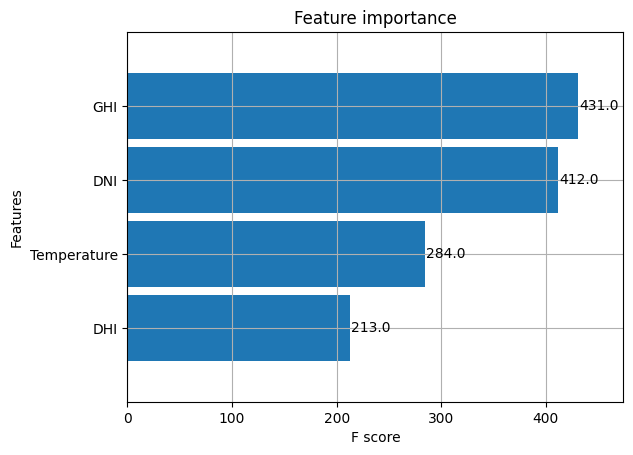

In [150]:
_ = plot_importance(xgb_model, height=0.9)

### Analysing feature importance using SHAP library

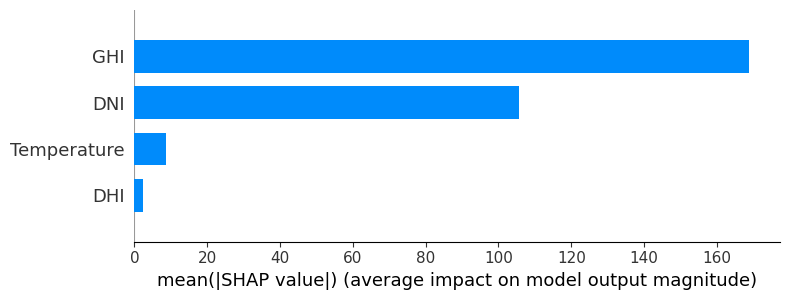

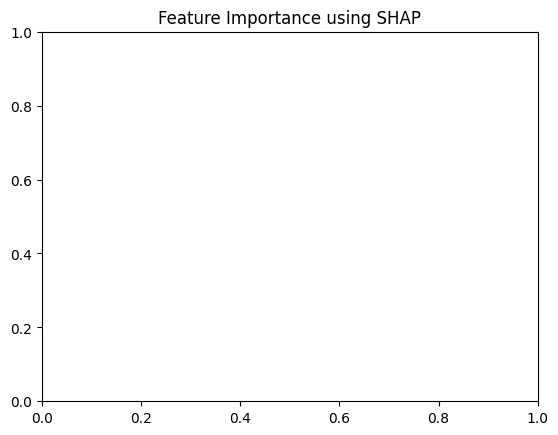

In [151]:
# Create the SHAP explainer for the model
explainer = shap.Explainer(xgb_model)

# Calculate SHAP values for the training set
shap_values = explainer(X_train)

# SHAP Summary Plot (Bar plot for feature importance)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train, plot_type="bar")
plt.title("Feature Importance using SHAP")
plt.show()

### **Conclusion**

In this study, we used the **XGBRegressor** model to predict the target variable based on a set of features, and evaluated its performance using key regression metrics on both the training and test datasets.

#### **Training Performance:**
The model achieved an outstanding **R² score of 1.00** on the training dataset, indicating that it explains **100%** of the variance in the target variable. This suggests that the model fits the training data perfectly and captures the underlying patterns effectively. The **Mean Squared Error (MSE)** on the training data was **263.65**, which is relatively low, indicating that the model’s predictions are close to the true values.

#### **Test Performance:**
When evaluating the model on the unseen test data, we observed that the model's performance remained excellent, with an **R² score** of **1.00** and an **MSE** of **263.65**. This suggests that the model performs consistently well on unseen data, explaining all the variance in the target variable. The **Mean Absolute Error (MAE)** of **7.18** and **Root Mean Squared Error (RMSE)** of **16.24** further validate that the model’s predictions are highly accurate with low error, even when tested on new data.

#### **Model Generalization:**
The perfect **R² score** on both the training and test datasets suggests that the model is generalizing extremely well, without overfitting to the training data. The low error values indicate that the model is making accurate predictions across both datasets, showcasing its ability to generalize effectively to new, unseen data.

#### **Implications and Future Work:**
The high **R²** and low **MSE**, **MAE**, and **RMSE** suggest that the model performs exceptionally well for this task. However, it is important to further evaluate the model's performance across different subsets of the data through techniques like cross-validation to ensure robustness across all scenarios. Future work could involve exploring advanced hyperparameter tuning, feature engineering, or integrating additional data sources to enhance the model’s predictive power. Additionally, analyzing the residuals and prediction error distribution could provide more insights into areas where the model may be underperforming or biased.

In conclusion, the **XGBRegressor** model demonstrates excellent predictive performance, accurately predicting the target variable in both training and testing datasets. The results suggest that the model is highly effective and can be leveraged for similar predictive tasks in real-world scenarios.
